In [7]:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scvi.dataset import CortexDataset, RetinaDataset
from scvi.models import VAE
from scvi.inference import UnsupervisedTrainer, load_posterior
from scvi import set_seed
import torch

# Control UMAP numba warnings
import warnings; warnings.simplefilter('ignore')
save_path = "data/"

# Sets torch and numpy random seeds, run after all scvi imports
set_seed(0)

In [85]:
import torch.nn as nn
import torch.nn.init as init
from scvi.dataset import GeneExpressionDataset
from typing import Tuple, Dict, Union
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal, kl_divergence as kl

from scvi.models.distributions import (
    ZeroInflatedNegativeBinomial,
    NegativeBinomial,
    Poisson,
)
from scvi.models.modules import Encoder, DecoderSCVI, LinearDecoderSCVI
from scvi.models.utils import one_hot

In [109]:
## define the discriminator
class Discriminator(nn.Module):
    def __init__(self, z_dim):
        super(Discriminator, self).__init__()
        self.z_dim = z_dim
        print("z_dim is {}".format(z_dim))
        self.net = nn.Sequential(
            nn.Linear(z_dim, 200),
            nn.LeakyReLU(0.2, True),
            nn.Linear(200, 200),
            nn.LeakyReLU(0.2, True),
            nn.Linear(200, 200),
            nn.LeakyReLU(0.2, True),
            nn.Linear(200, 200),
            nn.LeakyReLU(0.2, True),
            # nn.Linear(200, 200),
            # nn.LeakyReLU(0.2, True),
            nn.Linear(200, 2),
        )
        self.weight_init()

    def weight_init(self, mode='normal'):
        if mode == 'kaiming':
            initializer = kaiming_init
        elif mode == 'normal':
            initializer = normal_init

        for block in self._modules:
            for m in self._modules[block]:
                initializer(m)

    def forward(self, z):
        return self.net(z).squeeze()


In [110]:
def kaiming_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        init.kaiming_normal_(m.weight)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)


def normal_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        init.normal_(m.weight, 0, 0.02)
        if m.bias is not None:
            m.bias.data.fill_(0)
    elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d)):
        m.weight.data.fill_(1)
        if m.bias is not None:
            m.bias.data.fill_(0)


In [111]:
class FactorVAE(VAE):
    def __init__(
        self,
        n_input: int,
        n_batch: int = 0,
        n_labels: int = 0,
        n_hidden: int = 128,
        n_latent: int = 10,
        n_layers: int = 1,
        dropout_rate: float = 0.1,
        dispersion: str = "gene",
        log_variational: bool = True,
        reconstruction_loss: str = "zinb",
        latent_distribution: str = "normal"
    ):
        super().__init__(n_input, n_batch, n_labels, n_hidden, n_latent, n_layers,
                         dropout_rate, dispersion, log_variational,reconstruction_loss,
                         latent_distribution)
    def forward(
        self, x, local_l_mean, local_l_var, batch_index=None, y=None
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        """ Returns the reconstruction loss and the KL divergences
        :param x: tensor of values with shape (batch_size, n_input)
        :param local_l_mean: tensor of means of the prior distribution of latent variable l
         with shape (batch_size, 1)
        :param local_l_var: tensor of variancess of the prior distribution of latent variable l
         with shape (batch_size, 1)
        :param batch_index: array that indicates which batch the cells belong to with shape ``batch_size``
        :param y: tensor of cell-types labels with shape (batch_size, n_labels)
        :return: the reconstruction loss and the Kullback divergences
        """
        # Parameters for z latent distribution
        outputs = self.inference(x, batch_index, y)
        qz_m = outputs["qz_m"]
        qz_v = outputs["qz_v"]
        ql_m = outputs["ql_m"]
        ql_v = outputs["ql_v"]
        px_rate = outputs["px_rate"]
        px_r = outputs["px_r"]
        px_dropout = outputs["px_dropout"]

        # KL Divergence
        mean = torch.zeros_like(qz_m)
        scale = torch.ones_like(qz_v)

        kl_divergence_z = kl(Normal(qz_m, torch.sqrt(qz_v)), Normal(mean, scale)).sum(
            dim=1
        )
        kl_divergence_l = kl(
            Normal(ql_m, torch.sqrt(ql_v)),
            Normal(local_l_mean, torch.sqrt(local_l_var)),
        ).sum(dim=1)
        kl_divergence = kl_divergence_z

        reconst_loss = self.get_reconstruction_loss(x, px_rate, px_r, px_dropout)

        return reconst_loss + kl_divergence_l, kl_divergence, 0.0
        
        
        
        

In [112]:
class factorTrain(UnsupervisedTrainer):
    """The VariationalInference class for the unsupervised training of an autoencoder.
    Args:
        :model: A model instance from class ``VAE``, ``VAEC``, ``SCANVI``, ``AutoZIVAE``
        :discriminator: A discriminator
        :gene_dataset: A gene_dataset instance like ``CortexDataset()``
        :train_size: The train size, either a float between 0 and 1 or an integer for the number of training samples
         to use Default: ``0.8``.
        :test_size: The test size, either a float between 0 and 1 or an integer for the number of training samples
         to use Default: ``None``, which is equivalent to data not in the train set. If ``train_size`` and ``test_size``
         do not add to 1 or the length of the dataset then the remaining samples are added to a ``validation_set``.
        Two parameters can help control the training KL annealing
        If your applications rely on the posterior quality,
        (i.e. differential expression, batch effect removal), ensure the number of total
        epochs (or iterations) exceed the number of epochs (or iterations) used for KL warmup

        :n_epochs_kl_warmup: Number of epochs for linear warmup of KL(q(z|x)||p(z)) term. After `n_epochs_kl_warmup`,
                the training objective is the ELBO. This might be used to prevent inactivity of latent units, and/or to
                improve clustering of latent space, as a long warmup turns the model into something more of an autoencoder.
                Be aware that large datasets should avoid this mode and rely on n_iter_kl_warmup. If this parameter is not
                None, then it overrides any choice of `n_iter_kl_warmup`.
        :n_iter_kl_warmup: Number of iterations for warmup (useful for bigger datasets)
            int(128*5000/400) is a good default value.
        :normalize_loss: A boolean determining whether the loss is divided by the total number of samples used for
            training. In particular, when the global KL divergence is equal to 0 and the division is performed, the loss
            for a minibatchis is equal to the average of reconstruction losses and KL divergences on the minibatch.
            Default: ``None``, which is equivalent to setting False when the model is an instance from class
            ``AutoZIVAE`` and True otherwise.
        :\*\*kwargs: Other keywords arguments from the general Trainer class.
        int(400.0 * 5000 / 128.0)
    Examples:

    """
    default_metrics_to_monitor = ["elbo"]

    def __init__(
            self,
            model,
            gene_dataset: GeneExpressionDataset,
            train_size: Union[int, float] = 0.8,
            test_size: Union[int, float] = None,
            n_iter_kl_warmup: Union[int, None] = None,
            n_epochs_kl_warmup: Union[int, None] = 400,
            normalize_loss: bool = None,
            lr_D: float = 1e-4,
            beta1_D: float = 0.5,
            beta2_D: float = 0.9,
            **kwargs):
        super().__init__(model, gene_dataset, train_size, test_size, n_iter_kl_warmup,
                         n_epochs_kl_warmup, normalize_loss, **kwargs)
        self.D = Discriminator(self.model.n_latent)
        print("model n latent {}".format(model.n_latent))
        self.lr_D = lr_D
        self.beta1_D = beta1_D
        self.beta2_D = beta2_D
        self.optim_D = optim.Adam(self.D.parameters(), lr=self.lr_D,
                                  betas=(self.beta1_D, self.beta2_D))
        self.D_loss = 0.0
        (
            self.train_set,
            self.test_set,
            self.validation_set,
        ) = self.train_test_validation(model, gene_dataset, train_size, test_size)
        self.train_set.to_monitor = ["elbo"]
        self.test_set.to_monitor = ["elbo"]
        self.validation_set.to_monitor = ["elbo"]
        self.n_samples = len(self.train_set.indices)

    def reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = std.data.new(std.size()).normal_()
        return eps.mul(std).add_(mu)

    def permute_dims(self, z):
        assert z.dim() == 2

        B, _ = z.size()
        perm_z = []
        for z_j in z.split(1, 1):
            perm = torch.randperm(B).to(z.device)
            perm_z_j = z_j[perm]
            perm_z.append(perm_z_j)

        return torch.cat(perm_z, 1)

    def loss(self, tensors):

        sample_batch, local_l_mean, local_l_var, batch_index, y = tensors
        reconst_loss, kl_divergence_local, kl_divergence_global = self.model(
            sample_batch, local_l_mean, local_l_var, batch_index, y
        )
        loss = (
                self.n_samples
                * torch.mean(reconst_loss + self.kl_weight * kl_divergence_local)
                + kl_divergence_global
        )

        # print("n_batch is {}".format(sample_batch.shape))
        z_prime = self.model.get_latents(sample_batch, y)[0]
        # print("zPrime shape is {}".format(z_prime.shape))

        # qz_m = outputs["qz_m"]
        # qz_v = outputs["qz_v"]
        #
        # z_prime = self.reparametrize(qz_m, qz_v)
        z_pperm = self.permute_dims(z_prime).detach()
        D_z_pperm = self.D(z_pperm)
        D_z = self.D(z_prime)
        ones = torch.ones(sample_batch.shape[0], dtype=torch.long)
        zeros = torch.zeros(sample_batch.shape[0], dtype=torch.long)

        D_tc_loss = 0.5 * (F.cross_entropy(D_z, zeros) + F.cross_entropy(D_z_pperm, ones))

        if self.normalize_loss:
            loss = loss / self.n_samples
            D_tc_loss = D_tc_loss / self.n_samples

        return loss, D_tc_loss

    def on_training_loop(self, tensors_list):
        loss, D_loss = self.loss(*tensors_list)
        self.current_loss, self.D_loss = loss, D_loss
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.optim_D.zero_grad()
        D_loss.backward()
        self.optim_D.step()

In [113]:
### test the API

gene_dataset = CortexDataset(save_path=save_path, total_genes=None)
gene_dataset.subsample_genes(1000, mode="variance")
gene_dataset.make_gene_names_lower()


[2020-04-25 12:45:36,380] INFO - scvi.dataset.dataset | File /Users/ham112/Documents/GenomicVAE/data/expression.bin already downloaded
[2020-04-25 12:45:36,381] INFO - scvi.dataset.cortex | Loading Cortex data
[2020-04-25 12:45:53,372] INFO - scvi.dataset.cortex | Finished preprocessing Cortex data
[2020-04-25 12:45:54,825] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-25 12:45:54,827] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-25 12:45:57,421] INFO - scvi.dataset.dataset | Downsampling from 19972 to 1000 genes
[2020-04-25 12:45:57,584] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-25 12:45:57,622] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-04-25 12:45:57,731] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-25 12:45:57,737] INFO - scvi.dataset.dataset | Downsampled from 3005 to 3005 cells
[2020-04-25 12:45:57,746] INFO - scvi.dataset.dataset |

In [97]:
## setting up the hyper parameters
n_epochs = 2
lr = 1e-3
use_cuda = False
## setting up the training model
vae = VAE(gene_dataset.nb_genes)
trainer = UnsupervisedTrainer(
    vae,
    gene_dataset,
    train_size=0.90,
    use_cuda=use_cuda,
    frequency=5,
)
trainer.train(n_epochs=n_epochs, lr=lr)

[2020-04-23 15:49:51,422] INFO - scvi.inference.inference | KL warmup phase exceeds overall training phaseIf your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.
[2020-04-23 15:49:51,423] INFO - scvi.inference.inference | KL warmup for 400 epochs



[2020-04-23 15:49:55,158] INFO - scvi.inference.inference | Training is still in warming up phase. If your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.


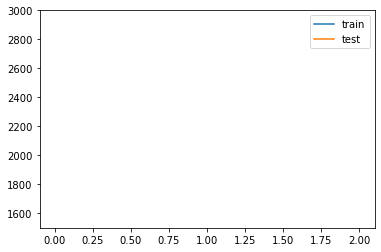

In [23]:
%matplotlib inline
elbo_train_set = trainer.history["elbo_train_set"]
elbo_test_set = trainer.history["elbo_test_set"]
x = np.linspace(0, 2, (len(elbo_train_set)))
plt.plot(x, elbo_train_set, label="train")
plt.plot(x, elbo_test_set, label="test")
plt.ylim(1500, 3000)
plt.legend()

In [114]:
## Test Factor VAE

factorVAE = FactorVAE(gene_dataset.nb_genes)
n_epochs = 2
lr = 1e-3
use_cuda = False
factortrainer = factorTrain(
    factorVAE,
    gene_dataset,
    train_size=0.90,
    use_cuda=use_cuda,
    frequency=5,
)


z_dim is 10
model n latent 10


In [103]:
type(factortrainer) is UnsupervisedTrainer

False

In [115]:
factortrainer.train(n_epochs=n_epochs, lr=lr)

[2020-04-25 12:46:07,198] INFO - scvi.inference.inference | KL warmup phase exceeds overall training phaseIf your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.
[2020-04-25 12:46:07,199] INFO - scvi.inference.inference | KL warmup for 400 epochs



[2020-04-25 12:46:11,748] INFO - scvi.inference.inference | Training is still in warming up phase. If your applications rely on the posterior quality, consider training for more epochs or reducing the kl warmup.
